In last notebook I achieved 82% accuracy, but it was unstable and a little sketchy, I want to master the technique here and try LSTM, maybe some scheduling and see how far I can push things. I'm also curious about stability of model, when it trained it jumped out of local minima.

In [1]:
import sys

sys.path.append("./../../src")


from Dataset import SpeechCommandsDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
test_dataset = SpeechCommandsDataset("./../../data/test")
train_dataset = SpeechCommandsDataset("./../../data/train")

In [3]:
class SpeechCommandGRU(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, num_layers=2, num_classes=35):
        super(SpeechCommandGRU, self).__init__()

        # Apply a 1D Conv to reduce dimensionality and extract features
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=80, stride=40),  # (16000 -> 400)
            nn.ReLU(),
            nn.Conv1d(32, input_size, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.squeeze(1)
        x = x.unsqueeze(1)  # (batch, 1, 16000)
        x = self.conv(x)  # (batch, input_size, time_steps)
        x = x.permute(0, 2, 1)  # (batch, time_steps, input_size)
        out, _ = self.rnn(x)  # (batch, time_steps, hidden_size*2)
        out = out[:, -1, :]  # Use last timestep
        out = self.fc(out)  # (batch, num_classes)
        return out

In [4]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for waveforms, labels in dataloader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)  # shape: (batch_size, num_classes)
            _, predicted = torch.max(outputs, 1)  # Get predicted class index
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.2%}")
    return accuracy

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)

model = SpeechCommandGRU(num_classes=30).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)
        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 3.3824
Epoch 2, Loss: 3.4453
Epoch 3, Loss: 3.3413
Epoch 4, Loss: 3.4319
Epoch 5, Loss: 3.4214
Epoch 6, Loss: 2.2239
Epoch 7, Loss: 0.8350
Epoch 8, Loss: 1.3686
Epoch 9, Loss: 0.0929
Epoch 10, Loss: 0.7756


In [6]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_accuracy = evaluate(model, test_loader, device)

Test Accuracy: 81.16%


Is there an error in data split those results are too good???

In [9]:
import glob

train_files = glob.glob("./../../data/train/**/*.wav", recursive=True)
test_files = glob.glob("./../../data/test/**/*.wav", recursive=True)
val_files = glob.glob("./../../data/validation/**/*.wav", recursive=True)

total_files = len(train_files) + len(test_files) + len(val_files)

print(f"Train: {len(train_files)}")
print(f"Test: {len(test_files)}")
print(f"Validation: {len(val_files)}")
print(f"Total WAV files: {total_files}")

Train: 51088
Test: 6835
Validation: 6798
Total WAV files: 64721


Doesn't seem like it

### Visualize learning process (acc and loss in epochs)

In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = SpeechCommandGRU(num_classes=30).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    # test_acc = evaluate(model, test_loader, device)
    # test_accuracies.append(test_acc)

    print(
        f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2%}"  # | Test Acc: {test_acc:.2%}"
    )

Epoch 1 | Train Loss: 3.3955 | Train Acc: 3.53%
Epoch 2 | Train Loss: 3.3937 | Train Acc: 3.67%
Epoch 3 | Train Loss: 3.3933 | Train Acc: 3.48%
Epoch 4 | Train Loss: 3.3510 | Train Acc: 4.65%
Epoch 5 | Train Loss: 1.5531 | Train Acc: 51.18%
Epoch 6 | Train Loss: 0.8426 | Train Acc: 73.89%
Epoch 7 | Train Loss: 0.6479 | Train Acc: 79.97%
Epoch 8 | Train Loss: 0.5420 | Train Acc: 83.25%
Epoch 9 | Train Loss: 0.4672 | Train Acc: 85.54%
Epoch 10 | Train Loss: 0.4066 | Train Acc: 87.48%
Epoch 11 | Train Loss: 0.3482 | Train Acc: 89.31%
Epoch 12 | Train Loss: 0.3041 | Train Acc: 90.46%
Epoch 13 | Train Loss: 0.2681 | Train Acc: 91.73%
Epoch 14 | Train Loss: 0.2428 | Train Acc: 92.47%
Epoch 15 | Train Loss: 0.2190 | Train Acc: 93.21%


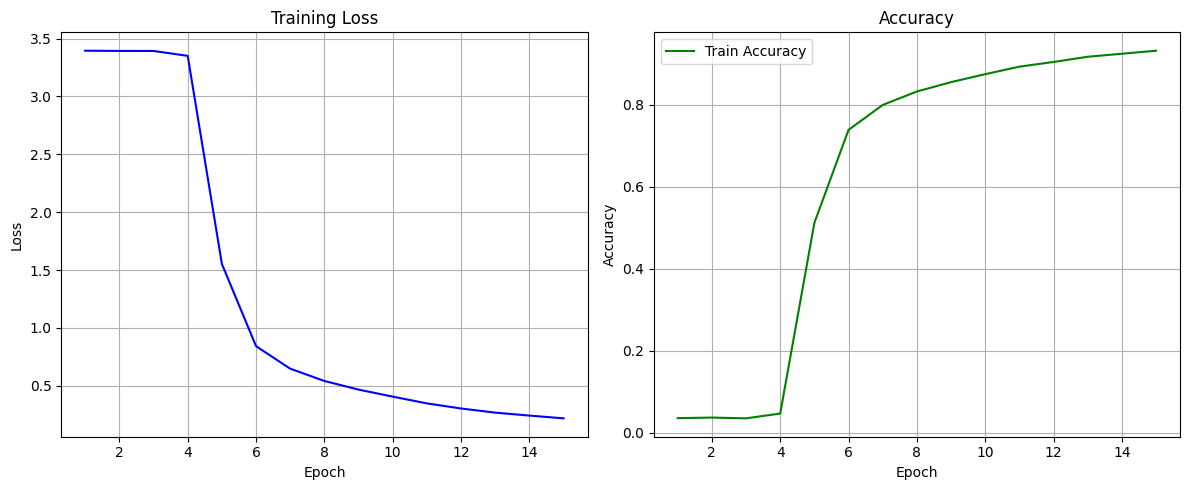

In [11]:
# Plot training loss and accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color="green")
# plt.plot(epochs, test_accuracies, label="Test Accuracy", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
evaluate(model, test_loader, device)

Test Accuracy: 86.69%


0.866861741038771